<a href="https://colab.research.google.com/github/phuocnguyen90/JobAnalysis/blob/main/Salary_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salary prediciton based on job description

Welcome to the second part of my analysis for a dataset on job postings for data related jobs in Vietnam market

[Link to the first notebook](https://colab.research.google.com/drive/1JblYhdVO5mUeDo_sB9-L0pyxea4ypb4)

[Link to the dataset]https://www.kaggle.com/datasets/phuocnguyen90/data-jobs-in-vietnam()

Quick links

[EDA](#EDA)

[Feature select, feature engineer](#FSFE)

  [XGBoost regression](#XGB)

  [Random forrest assemble](#RF)

  [Data engineer job testing](#DE)

  [Multivariate polynomial regression](#poly)

[Conclusion](#Conclusion)


In [3]:
# First, let's import some toolkits for the analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

!python -m spacy download en_core_web_md
#!pip install xgboost

2023-10-25 03:27:37.142922: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 03:27:37.142994: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 03:27:37.143039: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 03:27:39.674703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


**<a name = "EDA">Load the data, EDA</a>**

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import spacy
nlp = spacy.load('en_core_web_md')

In [5]:
df = pd.read_csv('Data_Jobs.csv', encoding='Windows-1252')

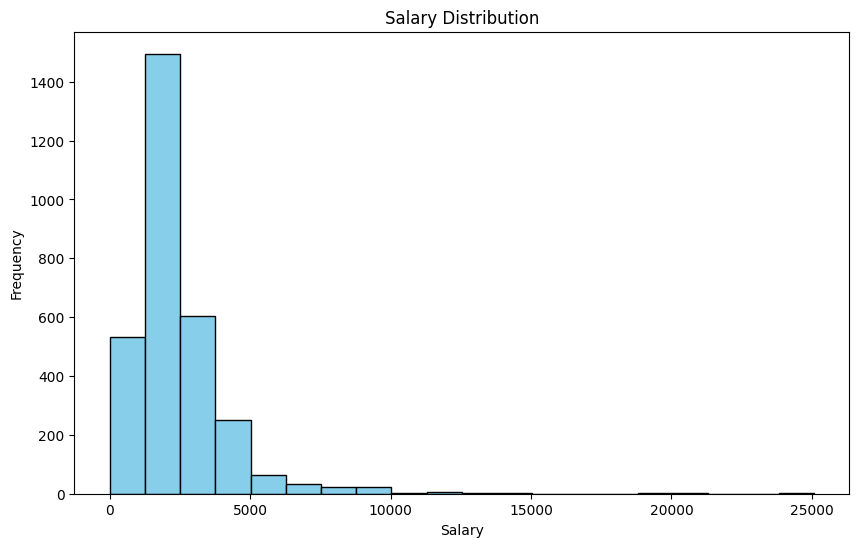

In [6]:
# Plot a histogram of salary values
plt.figure(figsize=(10, 6))
plt.hist(df['Est_Salary'], bins=20, color='skyblue', edgecolor='black')
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

In [7]:
# As we can see, the estimated salary data is rather skewed with a lot of outlier data, particularly for overseas jobs posted in Vietnam boards.
# Since the amount of data available for overseas market is rather small, it would be insufficient to create a seperate model for this analysis
# We should aim to more realistic expectations for Vietnam market
df = df[df['Est_Salary'] <= 6000]
df = df.dropna(subset=['Est_Salary'])

In [8]:
df['Est_Salary'].mean()

2264.131114130435

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2944 entries, 0 to 3186
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Job_ID                 2944 non-null   int64  
 1   Job_Title              2944 non-null   object 
 2   Min_YOE                2402 non-null   float64
 3   Est_Salary             2944 non-null   float64
 4   JD_Trans               2944 non-null   object 
 5   L1                     2937 non-null   float64
 6   L2                     1349 non-null   object 
 7   L3                     27 non-null     float64
 8   L4                     0 non-null      float64
 9   MinL                   2944 non-null   int64  
 10  Location               2935 non-null   object 
 11  VN                     2944 non-null   int64  
 12  Remote                 2944 non-null   int64  
 13  W_Term                 2944 non-null   object 
 14  W_Term_2               290 non-null    object 
 15  W_Te

Preprocessing some missing data

In [10]:
# Fix the missing values
# Fill missing values in 'W_Term' with 'Fulltime'

df['W_Term'].fillna('Fulltime', inplace=True)

# Fill missing values in 'Location' with 'VN'
df['Location'].fillna('VN', inplace=True)

job_categories = ['Data_Engineer', 'Data_Analyst', 'Data_Scientist', 'Business_Analyst', 'Business_Intelligence']

# Calculate the average YOE for each job category and round it
average_yoe_by_category = df.groupby(job_categories)['Min_YOE'].mean().round().reset_index()

# Fill in the missing 'Min_YOE' values based on the job category
for _, row in average_yoe_by_category.iterrows():
    condition = (df[job_categories] == tuple(row[job_categories])).all(axis=1)
    df.loc[condition, 'Min_YOE'] = row['Min_YOE']

# Fill any remaining missing 'Min_YOE' values with the overall average


df['L1'] = pd.to_numeric(df['L1'], errors='coerce')
df['L2'] = pd.to_numeric(df['L2'], errors='coerce')

In [11]:
df.head(5)


,Job_ID,Job_Title,Min_YOE,Est_Salary,JD_Trans,L1,L2,L3,L4,MinL,...,W_Term_2,W_Term_3,W_Term_4,Data_Engineer,Data_Analyst,Data_Scientist,Business_Analyst,Business_Intelligence,Combined_role,Others
0,5603,Senior Machine Learning,3.0,3390.0,Lang Ha Earable recruits Senior ML from 3 ++ y...,2.0,NaN,NaN,NaN,2,...,NaN,NaN,NaN,1,0,1,0,0,1,0
1,5602,Data Engineer,3.0,1270.0,HN-LLLL; Product Company recruits #data #engin...,1.0,2.0,NaN,NaN,1,...,NaN,NaN,NaN,1,0,0,0,0,0,0
2,5601,AI Research Engineer,3.0,2755.0,Cau Giay - HN - AI Research Engineer - 3-7year...,2.0,NaN,NaN,NaN,2,...,NaN,NaN,NaN,1,0,1,0,0,1,0
3,5600,Data Analyst,2.0,1270.0,Over 3 years of experience in data analysis.,2.0,NaN,NaN,NaN,2,...,NaN,NaN,NaN,0,1,0,0,0,0,0
4,5599,Data Engineer,3.0,1800.0,From 2 years of experience that has been worki...,1.0,NaN,NaN,NaN,1,...,NaN,NaN,NaN,1,0,0,0,0,0,0


The process of analyzing skill keywords were addressed quite carefully in the previous notebook. For the sake of simplicity, I have extracted all keywords from the previous notebook into a list

In [12]:
skills=['A/B Testing', 'Adaptability', 'Agile Methodologies', 'AI Ethics', 'AI Explainability', 'AI Fairness',
        'API Integration', 'Attention to Detail', 'Big Data', 'Business Acumen', 'Business Analysis',
        'Business Intelligence', 'Change Management', 'Classification', 'Client Management', 'Cloud Computing',
        'Clustering', 'Collaboration', 'Communication', 'Conflict Resolution', 'Containers', 'Creative Problem-Solving',
        'Creative Thinking', 'Critical Thinking', 'Dashboard Creation', 'Dashboard', 'Data Analysis',
        'Data Analytics', 'Data Architecture', 'Data Auditing', 'Data Augmentation', 'Data Catalog', 'Data Cleaning',
        'Data Cleansing', 'Data Collection', 'Data Driven', 'Data Engineering', 'Data Ethics', 'Data Exploration',
        'Data Governance', 'Data Imputation', 'Data Integration', 'Data Interpretation', 'Data Lake',
        'Data Lake Management', 'Data Lineage', 'Data Management', 'Data Manipulation', 'Data Migration', 'Data Mining',
        'Data Modeling', 'Data Monetization', 'Data Normalization', 'Data Pipelines', 'Data Preprocessing', 'Data Privacy',
        'Data Profiling', 'Data Quality', 'Data Reporting', 'Data Reshaping', 'Data Science',
        'Data Scrubbing', 'Data Security', 'Data Stewardship', 'Data Storytelling', 'Data Strategy', 'Data Testing',
        'Data Transformation', 'Data Validation', 'Data Visualization', 'Data Warehousing',
        'Data Wrangling', 'Database Design', 'Database Management', 'Data-Driven',
        'Decision-Making', 'Deep Learning', 'Dimensionality Reduction', 'Distributed Computing', 'Django', 'Docker',
        'Domain Knowledge', 'EDA', 'Ensemble', 'Ethical', 'ETL', 'Excel', 'Experimental Design',
        'FastAPI', 'Feature Engineering', 'Feature Scaling', 'Feature Selection', 'flask', 'Frameworks', 'GDPR',
        'Geospatial Analysis', 'Git', 'Gradient Boosting', 'Hadoop', 'Hypothesis Testing', 'Informatica', 'Interpersonal Skills',
        'Kanban', 'Leadership', 'Libraries', 'Machine Learning', 'Mathematics', 'Matplotlib', 'ML', 'Model Deployment',
        'Model Interpretation', 'Natural Language Processing ', 'NLP', 'nltk', 'NoSQL', 'Numpy', 'Pandas', 'Power BI',
        'Predictive Modeling', 'Presentation', 'Privacy compliance', 'Problem Definition', 'Problem Solving',
        'Project Management', 'Project Planning', 'Python', 'PyTorch', 'Quantitative Analysis', 'Query Optimization',
        'R', 'Random Forest', 'Regression Analysis', 'Reinforcement Learning', 'Requirements Gathering',
        'Sampling Techniques', 'Scikit-learn', 'Scrum', 'spacy', 'Spark', 'SQL', 'Stakeholder Management', 'Statistical Analysis',
        'Statistical Testing', 'Statistical Thinking', 'Strategic Thinking', 'Supervised Learning', 'Tableau', 'Teamwork',
        'TensorFlow', 'Text Processing', 'Time Management', 'Time Series',
        'Unsupervised Learning','vba', 'Version Control ', 'Web Scraping', 'Seaborn', 'XGBoost',
]

The aim of this task is to figure out the relationships between the job description with the estimated salary.

Next I'll develop some helper functions to extract skill keywords from a particular job description. This function will both search for exact match and semantic match via cosine similarity, based on a smaller NLP model, spaCy vectorizer

In [13]:
def phrase_tokenizer(text):

  # Tokenize the job description
  doc = nlp(text)

  # Extract noun phrases while retaining the original text
  noun_phrases = []
  for chunk in doc.noun_chunks:
      noun_phrases.append(chunk.text)

  # Tokenized words
  tokens = [token.text for token in doc]
  return tokens



In [14]:
def skills_search(job_descriptions):

  # Tokenize the job description
  doc = nlp(job_descriptions)

  # Initialize lists to store found skills
  exact_matches = []
  semantic_matches = []

  # Iterate through tokens in the job description
  for token in doc:
      for skill in skills:
          # Exact match
          if token.text.lower() == skill.lower():
              exact_matches.append(skill)
          # Semantic similarity
          elif nlp(token.text).similarity(nlp(skill)) > 0.7: #Edit the threshold here 0.7
              semantic_matches.append(skill)

  # Remove duplicates
  exact_matches = list(set(exact_matches))
  semantic_matches = list(set(semantic_matches))
  return exact_matches, semantic_matches


We'll need to save the vector table for all the keywords

In [15]:
#This function will take about a minute to create a vector table
def create_skill_encoding_table(skills, job_descriptions):
    # Create an empty DataFrame with columns for each skill
    skill_encoding_table = pd.DataFrame(columns=skills, dtype=int)

    # Loop through job descriptions and search for skills
    for job_description in job_descriptions:
        tokens = phrase_tokenizer(job_description)

        # Create a dictionary to represent skill presence (1 if found, 0 otherwise)
        skill_presence = {skill: 1 if skill.lower() in [token.lower() for token in tokens] else 0 for skill in skills}

        # Append the skill_presence dictionary as a new row to the DataFrame
        skill_encoding_table = skill_encoding_table.append(skill_presence, ignore_index=True)

    return skill_encoding_table

# Example usage

# Create the skill encoding table
# skill_table = create_skill_encoding_table(skills, df['JD_Trans'])
# Display the resulting DataFrame
# print(skill_table)


In [16]:
#The previous function is faster, but will provide a long list of eror. This function is longer, but no bug
def create_skill_encoding_table2(skills, job_descriptions):
    # Create an empty DataFrame with columns for each skill
    skill_encoding_table = pd.DataFrame(columns=skills, dtype=bool)

    # Loop through job descriptions and search for skills
    for job_description in job_descriptions:
        tokens = phrase_tokenizer(job_description)

        # Create a dictionary to represent skill presence (1 if found, 0 otherwise)
        skill_presence = {skill: 1 if skill.lower() in [token.lower() for token in tokens] else 0 for skill in skills}
        # Create a DataFrame from the skill_presence dictionary
        skill_presence_df = pd.DataFrame([skill_presence])

        # Concatenate the skill_presence_df to the skill_encoding_table
        skill_encoding_table = pd.concat([skill_encoding_table, skill_presence_df], ignore_index=True)

    return skill_encoding_table

# Create the skill encoding table
skill_table2 = create_skill_encoding_table2(skills, df['JD_Trans'])



# <a name = "FEFS">Feature engineering, feature selection </a>

In [31]:
import xgboost as xgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

#Since we'll try with different methods of feature engineering and selecting, I have created two helper functions to do the job

def feature_engineer(df, col_to_avg=None, col_to_encode=None, col_to_lbl=None, fill='NaN'):

    # Average the cols
    if col_to_avg is not None and len(col_to_avg) > 1:
        df['col_avg'] = df[col_to_avg].mean(axis=1)

    # One-hot encode the cols
    if col_to_encode is not None:
        df = pd.get_dummies(df, columns=col_to_encode, drop_first=True)

    # Label encode the cols
    if col_to_lbl is not None:
        label_encoder = LabelEncoder()
        for col in col_to_lbl:
            df[col] = label_encoder.fit_transform(df[col])

    # Fill the missing values
    if fill == 0:
        df.fillna(value=float(0), inplace=True)
    elif fill == 'NaN':
        df.fillna(value=float('NaN'), inplace=True)

    return df

def feature_select(df, features, skills=None):
    if skills is None:
        features = features
        target = 'Est_Salary'
    elif skills is not None:
        features = features+list(skills.columns)
        target = 'Est_Salary'
        df = df.join(skills, how='left')

    X = df[features]
    y = df[target]
    # Replace NaN values with 0 in your feature matrix (X)
    X = X.fillna(0)
    # Replace NaN values with 0 in your target variable (y) if needed
    y = y.fillna(0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test



In [ ]:
# Let's check again what data do we have here
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2944 entries, 0 to 3186
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Job_ID                 2944 non-null   int64  
 1   Job_Title              2944 non-null   object 
 2   Min_YOE                2944 non-null   float64
 3   Est_Salary             2944 non-null   float64
 4   JD_Trans               2944 non-null   object 
 5   L1                     2937 non-null   float64
 6   L2                     1349 non-null   float64
 7   L3                     27 non-null     float64
 8   L4                     0 non-null      float64
 9   MinL                   2944 non-null   int64  
 10  Location               2944 non-null   object 
 11  VN                     2944 non-null   int64  
 12  Remote                 2944 non-null   int64  
 13  W_Term                 2944 non-null   object 
 14  W_Term_2               290 non-null    object 
 15  W_Te

# <a name = "XGB">XGBoost regression</a>

In [18]:
xgb_df = feature_engineer(df,col_to_lbl=['Location','W_Term'])
xgb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2944 entries, 0 to 3186
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Job_ID                 2944 non-null   int64  
 1   Job_Title              2944 non-null   object 
 2   Min_YOE                2944 non-null   float64
 3   Est_Salary             2944 non-null   float64
 4   JD_Trans               2944 non-null   object 
 5   L1                     2937 non-null   float64
 6   L2                     1349 non-null   float64
 7   L3                     27 non-null     float64
 8   L4                     0 non-null      float64
 9   MinL                   2944 non-null   int64  
 10  Location               2944 non-null   int64  
 11  VN                     2944 non-null   int64  
 12  Remote                 2944 non-null   int64  
 13  W_Term                 2944 non-null   int64  
 14  W_Term_2               290 non-null    object 
 15  W_Te

In [21]:
#Feature selection

# Select the relevant features

features = ['Min_YOE', 'MinL', 'Location', 'Remote', 'W_Term', 'VN']
categorical_columns = ['Location', 'W_Term']

X_train, X_test, y_train, y_test = feature_select(xgb_df, features, skill_table2)

In [22]:
# Create and train the model (Random Forest Regressor, for example)
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)  # 'reg:squarederror' is used for regression tasks
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 652.4745980021504


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Calculate R-squared (R^2)
r2 = r2_score(y_test, y_pred)
print("R-squared (R^2):", r2)


Mean Absolute Error: 652.4745980021504
Mean Squared Error: 756233.902991332
Root Mean Squared Error: 869.6171013677986
R-squared (R^2): 0.4680994301093019


# Analysis

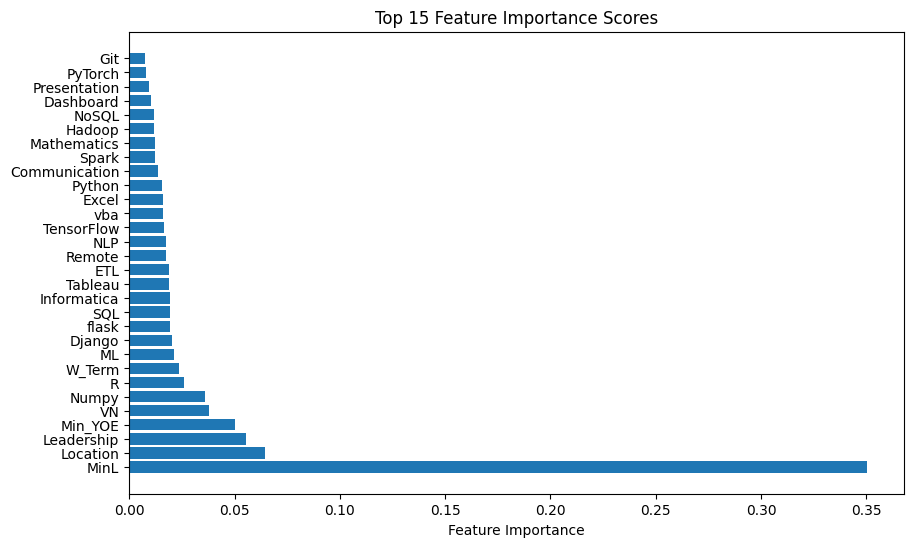

In [25]:
# Get feature importance scores
feature_importance = model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10-15 features
top_features = feature_importance_df.head(30)  # Change 15 to the desired number of top features

# Plot feature importance for the top features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance Scores')
plt.show()


# <a name = "RF">Random Forrest Ensemble</a>

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create the random forest regressor
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_rf = RandomForestRegressor(random_state=42, **best_params)
best_rf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = best_rf.predict(X_test)

# Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20}

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30}
Mean Absolute Error: 623.4881912411016


The orignial model gave a MAE of nearly 652. Given the average salary is $2200 per month, MAE is rather high.

Using RandomForest tree assemble method, we managed to get MAE down to 623

Let's see if other models can give a better result

# <a name = "DE">Focus on Data Engineer jobs</a>

In [41]:
#create another dataset and another table skills applicable only to DE
de_df = df[df['Data_Engineer'] == 1]

de_skills = create_skill_encoding_table2(skills, de_df['JD_Trans'])



<ipython-input-31-7d975117db0f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])
<ipython-input-31-7d975117db0f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])
<ipython-input-31-7d975117db0f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [45]:
# Engineer the features
combined_de_df = feature_engineer(de_df,col_to_lbl=['Location','W_Term']) #(df, col_to_avg=None, col_to_encode=None, col_to_lbl=None, fill='NaN')

# Select the relevant features
de_features = ['Min_YOE', 'MinL', 'Remote','W_Term','Location','VN']

X_de_train, X_de_test, y_de_train, y_de_test = feature_select(combined_de_df, de_features, de_skills)

# Create and train the model (Random Forest Regressor, for example)
de_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)  # 'reg:squarederror' is used for regression tasks
de_model.fit(X_de_train, y_de_train)

# Make predictions
y_de_pred = de_model.predict(X_de_train)

# Evaluate the model
de_mae = mean_absolute_error(y_de_train, y_de_pred)
print("Mean Absolute Error:", de_mae)

<ipython-input-31-7d975117db0f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])
<ipython-input-31-7d975117db0f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])
<ipython-input-31-7d975117db0f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Mean Absolute Error: 570.4456904484675


Without hyper-parameter tuning, MAE of DE jobs salary prediction reduced to 571, that is promising

In [51]:
# Define the parameter grid to search over

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create the random forest regressor
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
de_random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

de_random_search.fit(X_de_train, y_de_train)

# Get the best hyperparameters
de_best_params = de_random_search.best_params_
print("Best Hyperparameters:", de_best_params)

# Train the model with the best hyperparameters
de_best_rf = RandomForestRegressor(random_state=42, **de_best_params)
de_best_rf.fit(X_de_train, y_de_train)

# Evaluate the model on the test set
y_de_pred = de_best_rf.predict(X_de_test)

# Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20}

mae_de = mean_absolute_error(y_de_test, y_de_pred)
print("Mean Absolute Error:", mae_de)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Mean Absolute Error: 625.5524882797389


MAE = 625. It appears random forest cannot optimize better XGBoost in this case.

Let's see if a polynomial regression model could do better

# <a name = "poly">Polynomial regression</a>

<ipython-input-48-6e4d733c6f2d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Location'] = label_encoder.fit_transform(X['Location'])


Mean Squared Error: 871861.5610370494
Mean Squared Error: 647.6948156334417
R-squared: 0.3867721886746517


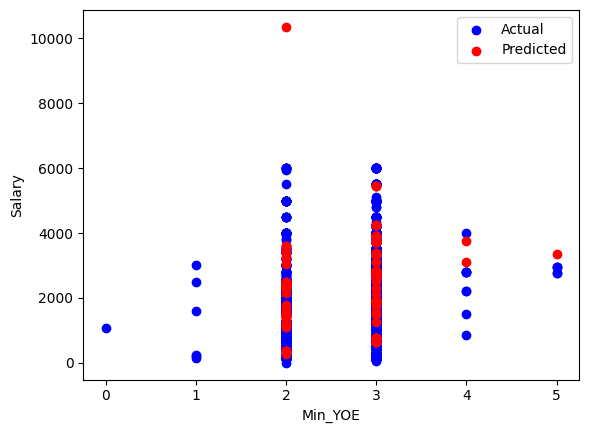

In [48]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target variable
features = ['Min_YOE', 'MinL', 'Remote', 'Location', 'W_Term', 'VN']
target = 'Est_Salary'

X = df[features]
y = df[target]

# Label encode the 'Location' feature
label_encoder = LabelEncoder()
X['Location'] = label_encoder.fit_transform(X['Location'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict salaries
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Squared Error: {mae}")
print(f"R-squared: {r2}")

# Plot the results
plt.scatter(X['Min_YOE'], y, color='blue', label='Actual')
plt.scatter(X_test['Min_YOE'], y_pred, color='red', label='Predicted')
plt.xlabel('Min_YOE')
plt.ylabel('Salary')
plt.legend()
plt.show()


In this case, MAE = 647



#<a name = "Conclusion">Conclusion</a>
It's safe to conclude with further fine-tuning and model selection, we can get a better result. However, given that the low quality of the dataset, we can get to a highest 77% accuracy (2450-571/2450) prediction which is not too bad. During running some other tests I could lower MAE to 510

In [53]:
de_df['Est_Salary'].mean()

2449.6006256517207